# Evaluate the performance of the different models by using a sliding window approach

Steps:
1. Harmonize the predictions to have the same format
2. Extract the frequencies using a sliding window approach
3. Evaluate the performance of the models
4. Visualize the results

## Step 1: Harmonize the predictions

In [27]:
import numpy as np
import pandas as pd
import respiration.utils as utils

signals_dir = utils.dir_path('outputs', 'signals')

In [28]:
raft_file = utils.join_paths(signals_dir, 'raft_predictions.csv')
raft_predictions = pd.read_csv(raft_file)
raft_predictions['signal'] = raft_predictions['signal_v'].apply(eval).apply(np.array)

# Only keep the chest roi predictions
raft_predictions = raft_predictions[raft_predictions['roi'] == 'chest']

# Only keep the columns that are needed
raft_predictions = raft_predictions[['subject', 'setting', 'model', 'signal']]

raft_predictions.head()

,subject,setting,model,signal
1,Proband01,101_natural_lighting,raft_large,"[-0.046315472573041916, -0.08250490576028824, ..."
4,Proband01,101_natural_lighting,raft_small,"[-0.031725313514471054, -0.021138720214366913,..."
7,Proband02,101_natural_lighting,raft_large,"[0.004266717471182346, -0.023671478033065796, ..."
10,Proband02,101_natural_lighting,raft_small,"[-0.01642800122499466, 0.0195891335606575, 0.0..."
13,Proband03,101_natural_lighting,raft_large,"[0.0041928417049348354, -0.011556083336472511,..."


In [29]:
flownet_file = utils.join_paths(signals_dir, 'flownet_predictions.csv')
flownet_predictions = pd.read_csv(flownet_file)
flownet_predictions['signal'] = flownet_predictions['signal_v'].apply(eval).apply(np.array)

# Only keep the chest roi predictions
flownet_predictions = flownet_predictions[flownet_predictions['roi'] == 'chest']

# Only keep the columns that are needed
flownet_predictions = flownet_predictions[['subject', 'setting', 'model', 'signal']]

flownet_predictions.head()

,subject,setting,model,signal
1,Proband01,101_natural_lighting,FlowNet2,"[-0.00023249644436873496, -0.00023353847791440..."
4,Proband01,101_natural_lighting,FlowNet2C,"[-62.82395553588867, -62.83050537109375, -62.7..."
7,Proband01,101_natural_lighting,FlowNet2CS,"[-48.91574478149414, -48.912803649902344, -48...."
10,Proband01,101_natural_lighting,FlowNet2CSS,"[-31.059289932250977, -31.22064208984375, -31...."
13,Proband01,101_natural_lighting,FlowNet2S,"[-0.43838709592819214, -0.4331112504005432, -0..."


In [30]:
pretrained_file = utils.join_paths(signals_dir, 'pretrained_predictions.csv')
pretrained_predictions = pd.read_csv(pretrained_file)
pretrained_predictions['signal'] = pretrained_predictions['signal'].apply(eval).apply(np.array)

# Only keep the columns that are needed
pretrained_predictions = pretrained_predictions[['subject', 'setting', 'model', 'signal']]

pretrained_predictions.head()

,subject,setting,model,signal
0,Proband01,101_natural_lighting,mtts_can,"[0.554201602935791, 0.9685323238372803, 1.1623..."
1,Proband01,101_natural_lighting,big_small,"[-0.005778029561042786, -0.013538409024477005,..."
2,Proband02,101_natural_lighting,mtts_can,"[0.2785760760307312, 0.1348249316215515, 0.488..."
3,Proband02,101_natural_lighting,big_small,"[-0.5870521664619446, -0.6804308891296387, -0...."
4,Proband03,101_natural_lighting,mtts_can,"[-0.07853958010673523, -0.42475640773773193, -..."


In [31]:
lucas_kanade_file = utils.join_paths(signals_dir, 'lucas_kanade.csv')
lucas_kanade = pd.read_csv(lucas_kanade_file)
lucas_kanade['signal'] = lucas_kanade['signal'].apply(eval).apply(np.array)

# Rename column method to model
lucas_kanade.rename(columns={'method': 'model'}, inplace=True)

# Remove all the rows that have a signal with a length of 0
lucas_kanade = lucas_kanade[lucas_kanade['grey'] == False]

# Only keep the columns that are needed
lucas_kanade = lucas_kanade[['subject', 'setting', 'model', 'signal']]

lucas_kanade.head()

,subject,setting,model,signal
0,Proband01,101_natural_lighting,lucas_kanade_cgof,"[566.1892881912896, 566.1583861238988, 566.090..."
1,Proband01,101_natural_lighting,lucas_kanade,"[569.9464284117253, 569.8949780022082, 569.838..."
4,Proband02,101_natural_lighting,lucas_kanade_cgof,"[575.59385902618, 575.574281238526, 575.574272..."
5,Proband02,101_natural_lighting,lucas_kanade,"[575.5011444858751, 575.4824881353312, 575.475..."
8,Proband03,101_natural_lighting,lucas_kanade_cgof,"[560.2775401023979, 560.277917737341, 560.2593..."


In [32]:
pixel_intensity_file = utils.join_paths(signals_dir, 'pixel_intensity.csv')
pixel_intensity = pd.read_csv(pixel_intensity_file)
pixel_intensity['signal'] = pixel_intensity['signal'].apply(eval).apply(np.array)

# Rename column method to model
pixel_intensity.rename(columns={'method': 'model'}, inplace=True)

# Only keep the columns that are needed
pixel_intensity = lucas_kanade[['subject', 'setting', 'model', 'signal']]

pixel_intensity.head()

,subject,setting,model,signal
0,Proband01,101_natural_lighting,lucas_kanade_cgof,"[566.1892881912896, 566.1583861238988, 566.090..."
1,Proband01,101_natural_lighting,lucas_kanade,"[569.9464284117253, 569.8949780022082, 569.838..."
4,Proband02,101_natural_lighting,lucas_kanade_cgof,"[575.59385902618, 575.574281238526, 575.574272..."
5,Proband02,101_natural_lighting,lucas_kanade,"[575.5011444858751, 575.4824881353312, 575.475..."
8,Proband03,101_natural_lighting,lucas_kanade_cgof,"[560.2775401023979, 560.277917737341, 560.2593..."


In [33]:
r_ppg_path = utils.join_paths(signals_dir, 'r_ppg_predictions.csv')

r_ppg_prediction = pd.read_csv(r_ppg_path)
r_ppg_prediction['signal'] = r_ppg_prediction['signal'].apply(eval).apply(np.array)

# Only keep the columns that are needed
r_ppg_prediction = r_ppg_prediction[['subject', 'setting', 'model', 'signal']]
r_ppg_prediction.head()

,subject,setting,model,signal
0,Proband01,101_natural_lighting,BP4D_PseudoLabel_TSCAN,"[0.1003175675868988, 0.4112994968891144, 0.678..."
1,Proband01,101_natural_lighting,MA-UBFC_tscan,"[-0.5689785480499268, -0.3492545187473297, -0...."
2,Proband01,101_natural_lighting,PURE_TSCAN,"[0.2524776756763458, -0.23906010389328003, -0...."
3,Proband01,101_natural_lighting,SCAMPS_TSCAN,"[1.1077316999435425, 0.7577620148658752, -1.23..."
4,Proband01,101_natural_lighting,UBFC-rPPG_TSCAN,"[-0.0640445351600647, -0.2270553708076477, -0...."


In [34]:
transformer_path = utils.join_paths(signals_dir, 'transformer_predictions.csv')

transformer_prediction = pd.read_csv(transformer_path)
transformer_prediction['signal'] = transformer_prediction['signal'].apply(eval).apply(np.array)

# Add a tf_ prefix to the model names
transformer_prediction['model'] = 'tf_' + transformer_prediction['model']

# Only keep the columns that are needed
transformer_prediction = transformer_prediction[['subject', 'setting', 'model', 'signal']]
transformer_prediction.head()

,subject,setting,model,signal
0,Proband21,303_normalized_face,tf_20240710_142159,"[-0.023982403799891472, -0.023851005360484123,..."
1,Proband22,303_normalized_face,tf_20240710_142159,"[-0.023859316483139992, -0.021364865824580193,..."
2,Proband23,303_normalized_face,tf_20240710_142159,"[0.029018523171544075, 0.02900373749434948, 0...."
3,Proband24,303_normalized_face,tf_20240710_142159,"[0.010098813101649284, 0.009706074371933937, 0..."
4,Proband25,303_normalized_face,tf_20240710_142159,"[-0.01839650236070156, -0.013670293614268303, ..."


In [35]:
#
# The random signal is used as a baseline to see how well the models perform against a random predictions
#
random_path = utils.join_paths(signals_dir, 'random_predictions.csv')

random_prediction = pd.read_csv(random_path)
random_prediction['signal'] = random_prediction['signal'].apply(eval).apply(np.array)

# Only keep the columns that are needed
random_prediction = random_prediction[['subject', 'setting', 'model', 'signal']]
random_prediction.head()

,subject,setting,model,signal
0,Proband01,101_natural_lighting,random,"[0.3745401188473625, 0.9507143064099162, 0.731..."
1,Proband02,101_natural_lighting,random,"[0.14122354337314946, 0.5708774168394762, 0.18..."
2,Proband03,101_natural_lighting,random,"[0.36901773241117275, 0.13551687356075404, 0.5..."
3,Proband04,101_natural_lighting,random,"[0.35121701963848806, 0.8372399995154594, 0.06..."
4,Proband05,101_natural_lighting,random,"[0.0381536059353772, 0.42981769814138193, 0.06..."


In [36]:
rhythm_former_path = utils.join_paths(signals_dir, 'rhythm_former.csv')

rhythm_former = pd.read_csv(rhythm_former_path)
rhythm_former['signal'] = rhythm_former['signal'].apply(eval).apply(np.array)

# Only keep the columns that are needed
rhythm_former = rhythm_former[['subject', 'setting', 'model', 'signal']]
rhythm_former.head()

,subject,setting,model,signal
0,Proband01,101_natural_lighting,MMPD_intra_RhythmFormer,"[6.791207790374756, 3.5748708248138428, 1.2099..."
1,Proband01,101_natural_lighting,PURE_cross_RhythmFormer,"[-0.8188962936401367, -1.1508585214614868, -1...."
2,Proband01,101_natural_lighting,UBFC_cross_RhythmFormer,"[-0.4842113256454468, 0.1762332320213318, 1.22..."
3,Proband02,101_natural_lighting,MMPD_intra_RhythmFormer,"[7.461903095245361, 7.302515506744385, 9.02933..."
4,Proband02,101_natural_lighting,PURE_cross_RhythmFormer,"[-1.0978111028671265, -1.8195456266403198, -2...."


In [37]:
predictions = pd.concat([
    raft_predictions,
    flownet_predictions,
    pretrained_predictions,
    lucas_kanade,
    pixel_intensity,
    r_ppg_prediction,
    transformer_prediction,
    random_prediction,
    rhythm_former,
])
len(predictions)

770

## Step 2: Extract the frequencies using a sliding window approach

In [38]:
from respiration.dataset import VitalCamSet

sample_rate = 30
dataset = VitalCamSet()

In [39]:
from tqdm.auto import tqdm
import respiration.analysis as analysis

experiment_analysis = analysis.Analysis(
    sample_rate=sample_rate,
)

for idx, row in tqdm(predictions.iterrows(), total=len(predictions)):
    subject, setting = row['subject'], row['setting']
    prediction = row['signal']
    model = row['model']
    gt_signal = dataset.get_breathing_signal(subject, setting)

    # Cut the gt_signal to have the same length as the prediction
    gt_signal = gt_signal[:len(prediction)]

    experiment_analysis.add_data(model, prediction, gt_signal)

  0%|          | 0/770 [00:00<?, ?it/s]

In [40]:
analysis_dir = utils.dir_path('outputs', 'analysis')

In [41]:
results_table = experiment_analysis.metrics_df()
# results_table['MAE'] = results_table['MAE'].apply(lambda x: round(x * 60, 3))
# results_table['RMSE'] = results_table['RMSE'].apply(lambda x: round(x * 60, 3))

results_table.to_csv(utils.join_paths(analysis_dir, 'metrics.csv'), index=False)
results_table

,model,method,MAE,RMSE,PCC,PCC-p-value
0,raft_large,cp,0.061781,0.084957,0.215667,5.004059e-26
1,raft_large,nfcp,0.079850,0.104615,-0.055588,7.152664e-03
2,raft_large,pk,0.066923,0.092404,0.181504,8.840171e-19
3,raft_large,psd,0.028063,0.053740,0.745924,0.000000e+00
4,raft_small,cp,0.060114,0.080795,0.207100,4.379734e-24
...,...,...,...,...,...,...
127,PURE_cross_RhythmFormer,psd,0.136125,0.171959,0.105892,2.835356e-07
128,UBFC_cross_RhythmFormer,cp,0.185983,0.206570,-0.106703,2.295836e-07
129,UBFC_cross_RhythmFormer,nfcp,0.202244,0.218920,-0.136203,3.692229e-11
130,UBFC_cross_RhythmFormer,pk,0.205427,0.226561,-0.085841,3.211673e-05


In [42]:
results_table_x = results_table.copy()

# Calculate the MAE and RMSE in beats per minute (bpm)
results_table_x['MAE'] = results_table_x['MAE'].apply(lambda x: x * 60)
results_table_x['RMSE'] = results_table_x['RMSE'].apply(lambda x: x * 60)

# Calculate the PCC in absolute values
# results_table_x['PCC'] = results_table_x['PCC'].apply(lambda x: abs(x))

# Remove the cp method, because we use the improved nfcp method
results_table_x = results_table_x[(results_table_x['method'] == 'pk') |
                                  (results_table_x['method'] == 'psd')]

# Calculate the average RMSE for each model
average_metric = results_table_x.groupby('model')['MAE'].mean().reset_index()
average_metric['MAE'] = average_metric['MAE'].apply(lambda x: round(x, 3))
average_metric['MAE_std'] = results_table_x.groupby('model')['MAE'].std().values

# Add the averaged RMSE for each model
average_metric['RMSE'] = results_table_x.groupby('model')['RMSE'].mean().values
average_metric['RMSE'] = average_metric['RMSE'].apply(lambda x: round(x, 3))
average_metric['RMSE_std'] = results_table_x.groupby('model')['RMSE'].std().values

# Add the averaged PCC for each model
average_metric['PCC'] = results_table_x.groupby('model')['PCC'].mean().values
average_metric['PCC'] = average_metric['PCC'].apply(lambda x: round(x, 3))
average_metric['p-value'] = results_table_x.groupby('model')['PCC-p-value'].mean().values
average_metric['p-value'] = average_metric['p-value'].apply(lambda x: round(x, 3))

# Store the results
average_metric.to_csv(utils.join_paths(analysis_dir, 'average_metrics.csv'), index=False)

average_metric

,model,MAE,MAE_std,RMSE,RMSE_std,PCC,p-value
0,BP4D_PseudoLabel_DeepPhys,7.228,1.575579,8.733,1.150998,0.068,0.108
1,BP4D_PseudoLabel_TSCAN,7.849,0.972423,9.138,0.684086,-0.031,0.000
2,FlowNet2,3.345,1.380369,5.102,0.855517,0.435,0.000
3,FlowNet2C,3.349,0.115434,5.142,0.485080,0.469,0.000
4,FlowNet2CS,2.735,0.316083,4.485,0.556428,0.550,0.000
5,FlowNet2CSS,3.466,0.056206,5.483,0.948954,0.414,0.000
6,FlowNet2S,2.847,1.244387,4.523,1.209951,0.516,0.000
7,FlowNet2SD,3.213,0.839463,5.110,0.443867,0.409,0.000
8,MA-UBFC_deepphys,8.044,1.746614,9.410,1.629266,-0.006,0.000
9,MA-UBFC_tscan,8.017,2.120112,9.479,1.790456,0.007,0.000


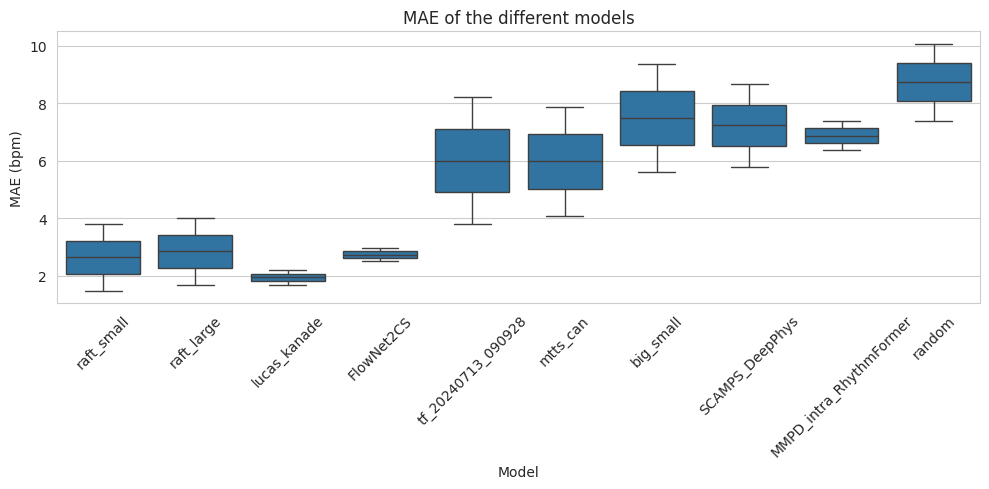

In [43]:
# Plot the MAE for the following models
model_selection = [
    "lucas_kanade",
    "FlowNet2CS",
    "raft_small",
    "raft_large",
    "mtts_can",
    "tf_20240713_090928",
    "MMPD_intra_RhythmFormer",
    "SCAMPS_DeepPhys",
    "big_small",
    "random",
]

xxx = results_table_x[results_table_x['model'].isin(model_selection)]

# Sort the models by the average MAE
xxx = xxx.sort_values('MAE')

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Boxplot with std
sns.boxplot(data=xxx, x='model', y='MAE')

plt.xticks(rotation=45)
plt.ylabel('MAE (bpm)')
plt.xlabel('Model')
plt.title('MAE of the different models')
plt.tight_layout()

plt.show()

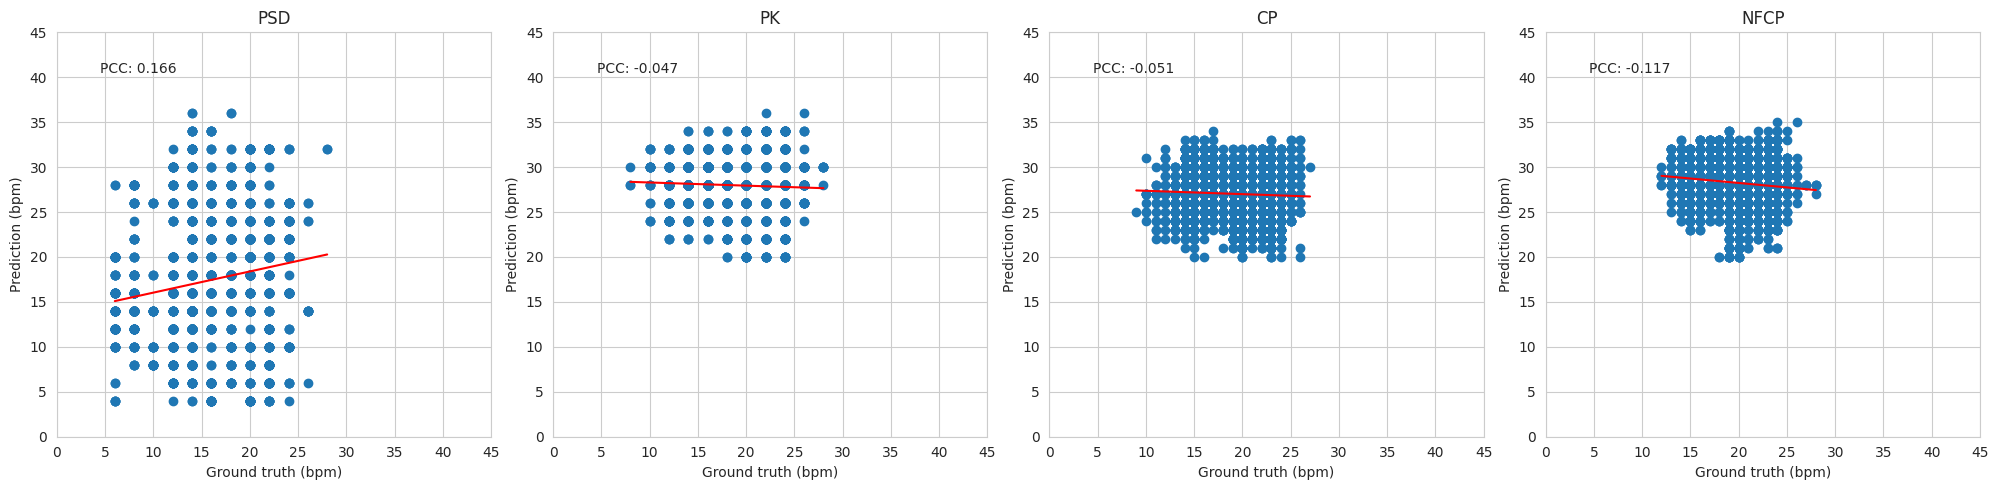

In [44]:
model = "big_small"

# Create a bland-altman plot for the following models
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for idx, metric in enumerate(["psd", "pk", "cp", "nfcp"]):
    preds = experiment_analysis.prediction_metrics[model][metric]
    gts = experiment_analysis.ground_truth_metrics[model][metric]

    # Transform the values from Hz to beats per minute
    preds = preds * 60
    gts = gts * 60

    # Scatter plot
    axs[idx].scatter(gts, preds, label=metric)
    axs[idx].set_title(f'{metric.upper()}')

    pcc = np.corrcoef(gts, preds)[0, 1]
    axs[idx].text(0.1, 0.9, f'PCC: {round(pcc, 3)}', transform=axs[idx].transAxes)
    # Add a trend line
    axs[idx].plot(np.unique(gts), np.poly1d(np.polyfit(gts, preds, 1))(np.unique(gts)), color='red')

    # Show the range 0 to 35 for the x- and y-axis
    axs[idx].set_xlim(0, 45)
    axs[idx].set_ylim(0, 45)

    # Name the x- and y-axis
    axs[idx].set_xlabel('Ground truth (bpm)')
    axs[idx].set_ylabel('Prediction (bpm)')

plt.tight_layout()
plt.show()